In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from models.galaxy import Galaxy
from models.space import Space
from models.equations import velocity, null_gravity

# Mass profile

In [2]:
def D(x, x4=519, x3=1630, x2=1844, x1=889, x0=155):
    # https://spacemath.gsfc.nasa.gov/weekly/6Page102.pdf
    return x4*x**4 - x3*x**3 + x2*x**2 - x1*x + x0

In [3]:
boost = 50
points = 4*boost+1
radius = points/4
space = Space((points, points, points), 4/points)
r, z = space.rz()
x = (r**2+z**2)**0.5
mass = D(x)
mass[x > 1] = 0 # outside of the mass
mass[mass < 0] = 0 # negative masses
mass /= np.sum(mass) # normalise mass, so it's units of solar masses

In [4]:
mass2 = space.blank()
mass2[tuple(space.center)] = 1.0

<AxesSubplot:>

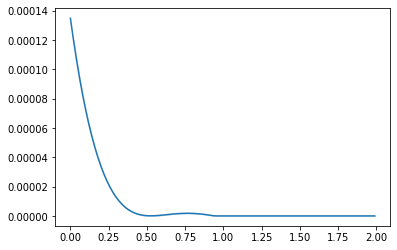

In [5]:
sns.lineplot(x=x[space.center[0]][space.center[1]], y=mass[space.center[0]][space.center[1]])

# Generate results

In [6]:
simulation = Galaxy([mass, mass2], space)

In [7]:
simulation.analyse(simulation.radius_points(2, 20))

In [9]:
GAMMA = 20
ALPHA = 0.25

In [10]:
import matplotlib.pyplot as plt

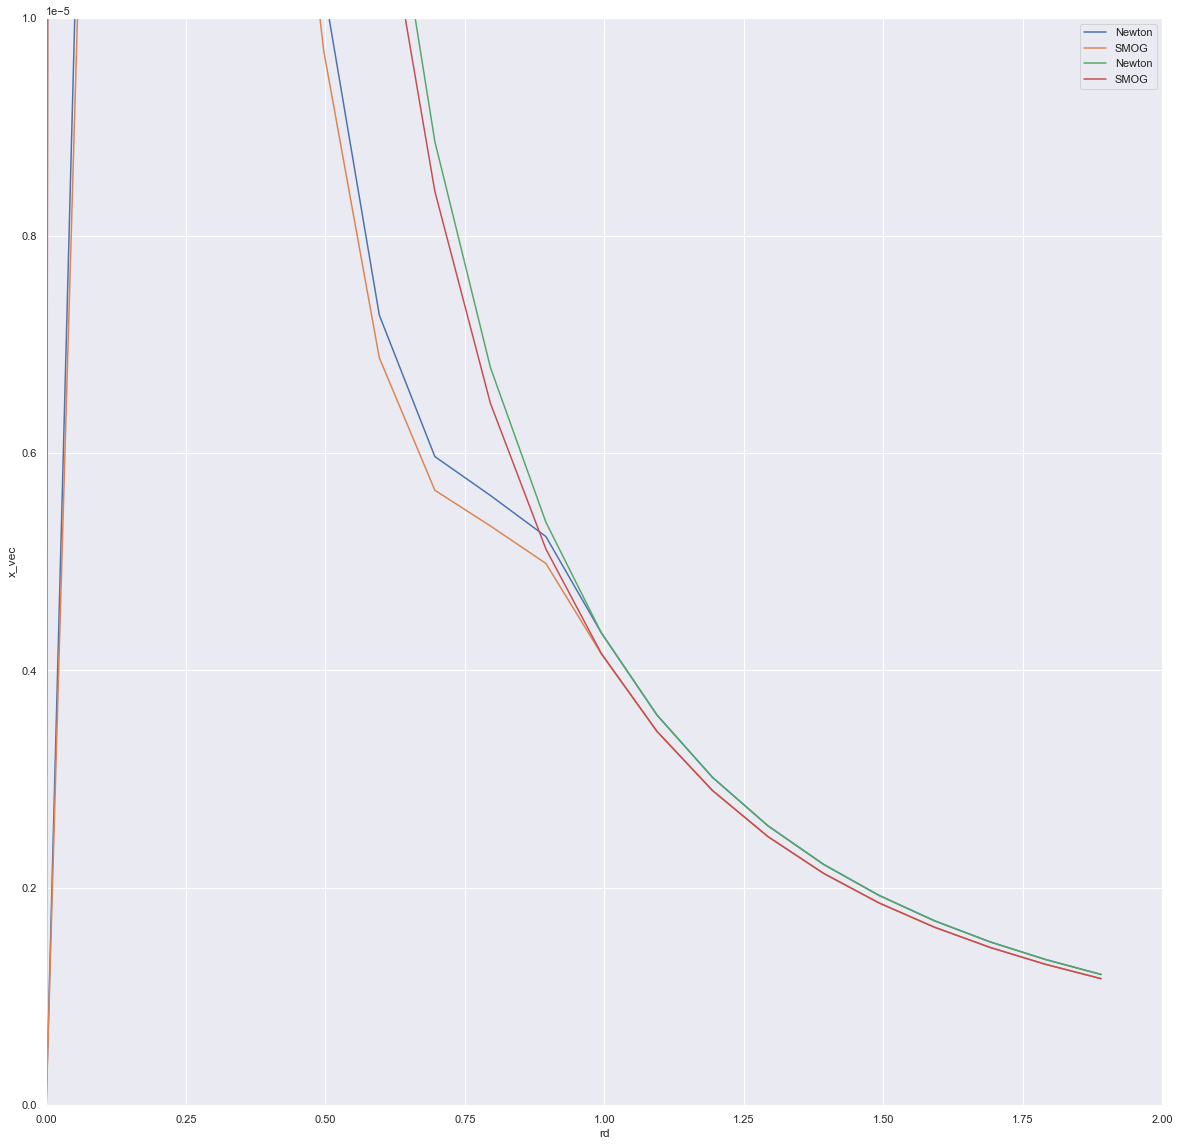

In [15]:
levels = []
sns.set(rc={"figure.figsize":(20, 20)})
for comp, df in simulation.dataframe().groupby('component'):
    #display(df)
    R = df['rd']
    Fnewton = df['x_vec']
    Fnulled1 = df['x_abs'] - df['x_vec']
    Fnulled2 = df['F_abs']
    Fnulled3 = np.sum([(df['%s_abs' % d]-df['%s_vec' % d])**2 for d in 'xyz'], axis=0)**0.5
    Fnulled = df['F_abs']#df['F_scalar']
    levels.append([Fnulled1, Fnulled2, Fnulled3])
    fnr = df[df['rd'] > 1]['x_vec'].to_numpy()[0]
    gamma = fnr/null_gravity(fnr, 0, 1, ALPHA)
    Fmod = null_gravity(Fnewton, Fnulled, gamma, ALPHA)
    sns.lineplot(x=R, y=Fnewton, label='Newton').set(xlim=(0,2), ylim=(0,0.00001))
    sns.lineplot(x=R, y=Fmod, label='SMOG')

<AxesSubplot:ylabel='F_abs'>

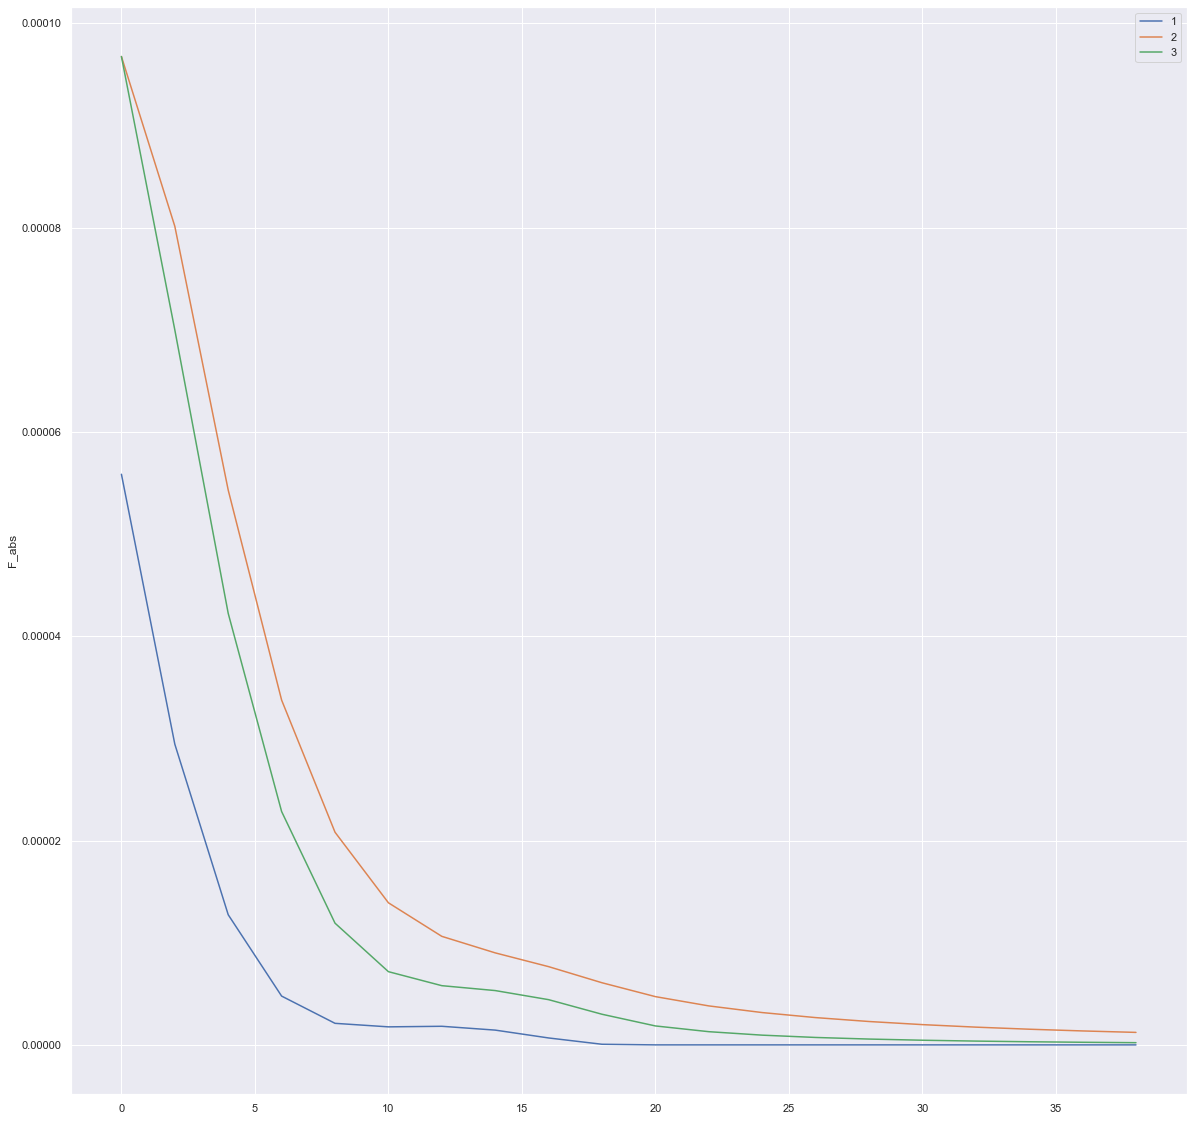

In [14]:
sns.lineplot(x=levels[0][0].index, y=levels[0][0], label='1')
sns.lineplot(x=levels[0][0].index, y=levels[0][1], label='2')
sns.lineplot(x=levels[0][0].index, y=levels[0][2], label='3')

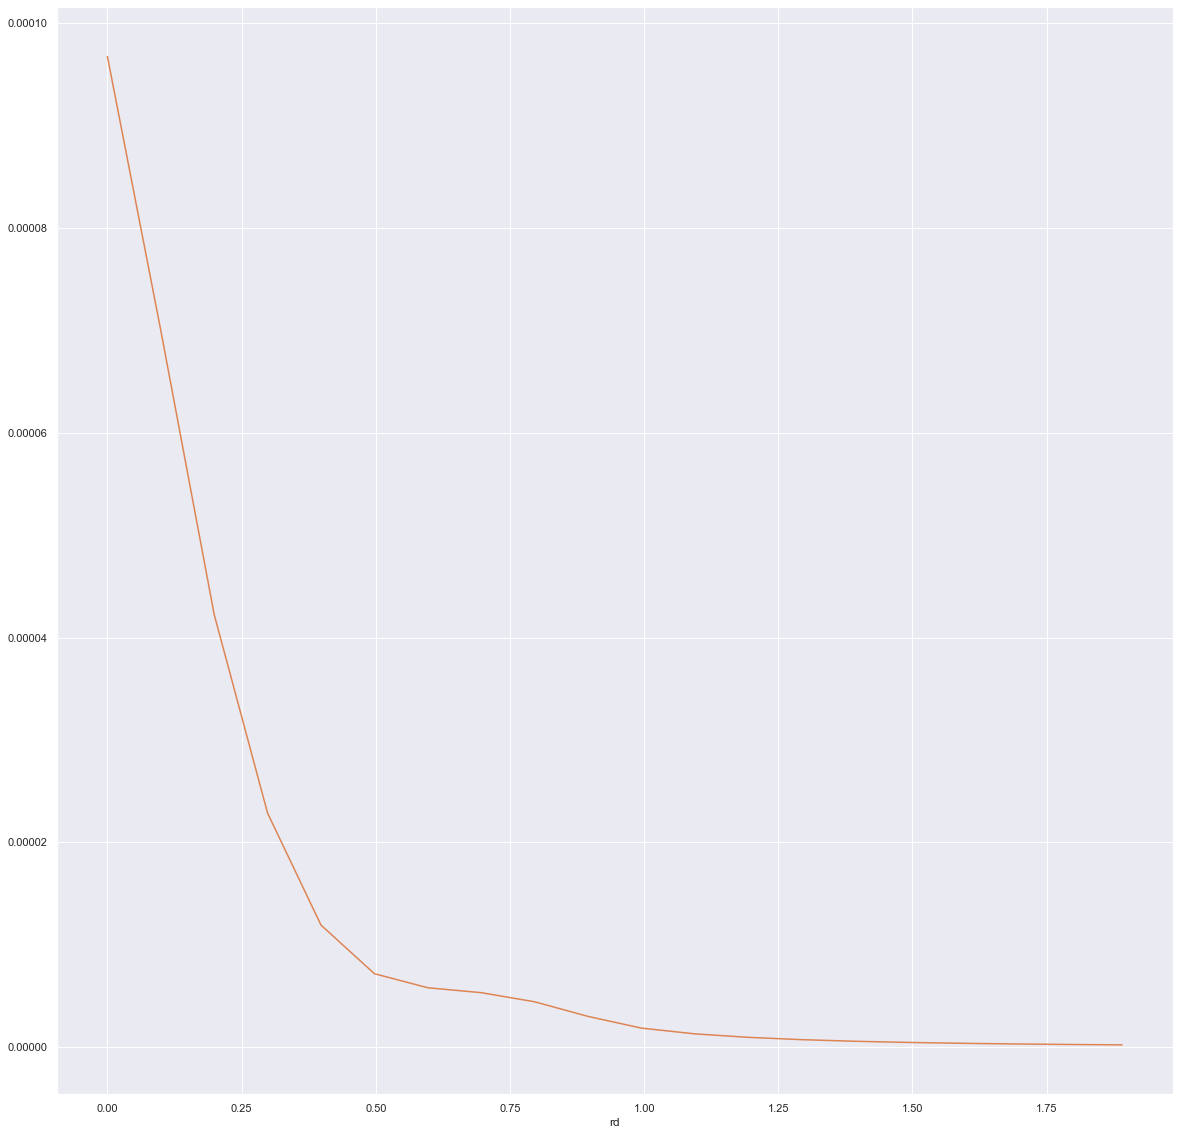

In [110]:
for level in levels[0]:
    sns.lineplot(x=df['rd'], y=level)

# Testing scalar version

<AxesSubplot:xlabel='rd', ylabel='x_vec'>

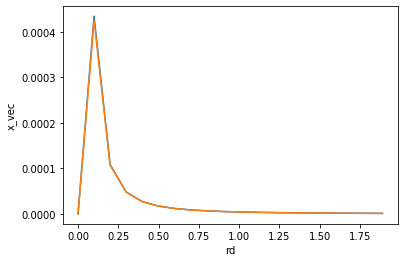

In [66]:
R = df['rd']
Fnewton = df['x_vec']
Fnulled = df['F_abs']
Fmod = null_gravity(Fnewton, Fnulled, 1, 0.5)
sns.lineplot(x=R, y=Fnewton)
sns.lineplot(x=R, y=Fmod)

[Text(0.5, 0, 'Radius (in units of Radius of Sun)'),
 Text(0, 0.5, '% difference in force values'),
 (0.0, 100.0)]

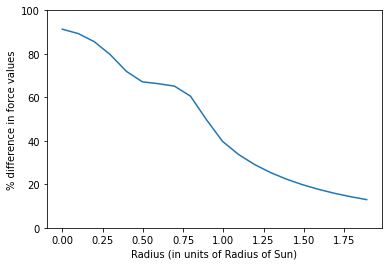

In [31]:
sns.lineplot(x=R, y=(Fnewton-Fmod)*100/Fnewton).set(xlabel='Radius (in units of Radius of Sun)', ylabel='% difference in force values', ylim=(0,100))

# Testing external field

In [41]:
def plot_func(func):
    tests = (0, 5, 100)
    fig, axes = plt.subplots(1, len(tests), figsize=(20,5))
    for i, tau in enumerate(tests):
        R = df['rd']
        Fnewton = df['x_vec']
        Fnulled = df['F_abs'] - df['F_vec']
        
        fnr = df[df['rd'] > 1]['x_vec'].to_numpy()[0]
        gamma = fnr/func(1, fnr, 0, tau)
        
        Fmod = func(gamma, Fnewton, Fnulled, tau)
        sns.lineplot(x=R, y=Fnewton, ax=axes[i])
        g = sns.lineplot(x=R, y=Fmod, ax=axes[i])
        sns.lineplot(x=R, y=(Fnewton-Fmod)*100/Fnewton, ax=g.twinx(), color='red', linestyle='dotted').set(ylim=(0,100))

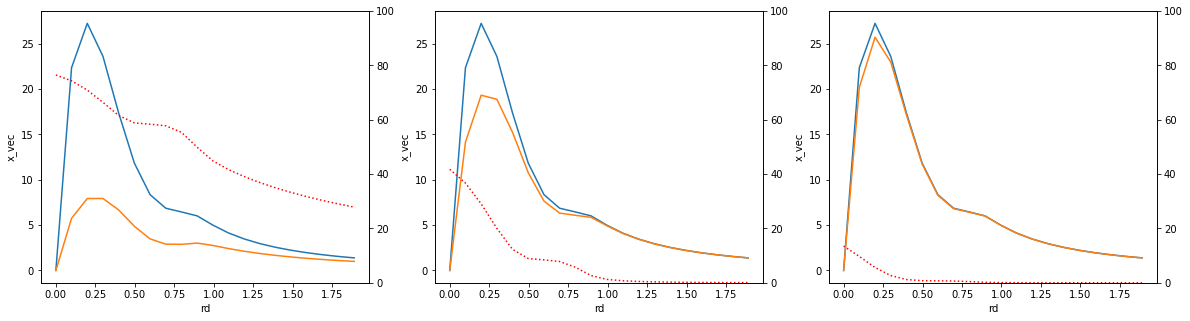

In [42]:
plot_func(lambda g,f,n,t: null_gravity(f, n, g, 0.25, tau=t))

In [ ]:
plot_func(lambda g,f,n,t: null_gravity(f, n, g, 1, 0.25, tau=t))